In [153]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.ops import unary_union

import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_predict, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance

In [2]:
# set seaborn theme
sns.set_theme(style='darkgrid')

In [3]:
loc_gdf = gpd.read_file('data/AQMS_loc.shp')
dep_df = pd.read_csv('data/hourly.csv')

# Initialise

In [ ]:
# set buffer zones around each site (1km)
loc_gdf['buffer_1km'] = loc_gdf['geometry'].buffer(1000)

In [ ]:
buffer_gdf = loc_gdf[['buffer_1km']]
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='buffer_1km')
buffer_gdf.to_file('data/buffer.shp')

## gsp modify

In [ ]:
loc_gdf

0575 - LH0

1065, 1070, 1565, 1570 - TD5

2565, 2570, 3065, 3070 - CR8

2565, 3065 - ST5

2080, 2580 - KC1

2580, 2585 - CD1

2580 - MY7

2580, 3080 - BL0, CD9

3080 - CT2, CT3

3570, 3575 - HP1, LW2

3575, 3580, 4075, 4080 - GN6

3580 - TH4

4070, 4075, 4570, 4575 - GB0

4070, 4075 - GR9, GR4

4075, 4575 - GN3

5075 - BX9

5080 - HV1

In [ ]:
def readin_Gsp(file_name, path='data/OSMM Greenspaces/tq/TQ', suffix='_GreenspaceArea.shp'):
    if type(file_name) == str:
        gdf = gpd.read_file(path+file_name+suffix)
    else:
        gdf = pd.concat(gpd.read_file(path+f+suffix) for f in file_name)
    return gdf

In [ ]:
loc_gdf['Gsp'] = gpd.GeoSeries()

In [ ]:
loc_gdf.columns.get_loc('Gsp')

In [ ]:
def get_Gsp(file_name, index):
    gdf = readin_Gsp(file_name)
    print('Finish reading in shapefile(s)')
    shp = gdf['geometry'].unary_union
    print('Finish unary union.')
    if type(index) == int:
        loc_gdf.iat[index, 4] = shp.intersection(loc_gdf.loc[index, 'buffer_1km'])
    elif type(index) == list:
        for i in index:
            loc_gdf.iat[i, 4] = shp.intersection(loc_gdf.loc[i, 'buffer_1km'])
    else:
        print('invalid type!')

In [ ]:
get_Gsp('0575', 13)
loc_gdf.loc[13, 'Gsp']

In [ ]:
get_Gsp(['1065','1070','1565','1570'], 17)
loc_gdf.loc[17, 'Gsp']

In [ ]:
get_Gsp(['2565','2570','3065','3070'], 6)
loc_gdf.loc[6, 'Gsp']

In [ ]:
get_Gsp(['2565','3065'], 18)
loc_gdf.loc[18, 'Gsp']

In [ ]:
get_Gsp(['2080','2580'], 14)
loc_gdf.loc[14, 'Gsp']

In [ ]:
get_Gsp(['2580','2585'], 3)
loc_gdf.loc[3, 'Gsp']

In [ ]:
get_Gsp('2580', 20)
loc_gdf.loc[20, 'Gsp']

In [ ]:
get_Gsp(['2580','3080'], [1,2])

In [ ]:
loc_gdf.loc[1, 'Gsp']

In [ ]:
loc_gdf.loc[2, 'Gsp']

In [ ]:
get_Gsp('3080', [4,5])

In [ ]:
loc_gdf.loc[4, 'Gsp']

In [ ]:
loc_gdf.loc[5, 'Gsp']

In [ ]:
get_Gsp(['3570','3575'], [15,16])

In [ ]:
loc_gdf.loc[15, 'Gsp']

In [ ]:
loc_gdf.loc[16, 'Gsp']

In [ ]:
get_Gsp(['3575','3580','4075','4080'], 9)
loc_gdf.loc[9, 'Gsp']

In [ ]:
get_Gsp('3580', 19)
loc_gdf.loc[19, 'Gsp']

In [ ]:
get_Gsp(['4070','4075','4570','4575'], 8)
loc_gdf.loc[8, 'Gsp']

In [ ]:
get_Gsp(['4075', '4575'], [7, 11])

In [ ]:
loc_gdf.loc[7, 'Gsp']

In [ ]:
loc_gdf.loc[11, 'Gsp']

In [ ]:
get_Gsp(['4075', '4575'], 10)
loc_gdf.loc[10, 'Gsp']

In [ ]:
get_Gsp('5075', 0)
loc_gdf.loc[0, 'Gsp']

In [ ]:
get_Gsp('5080', 12)
loc_gdf.loc[12, 'Gsp']

In [ ]:
Gsp_gdf = loc_gdf[['siteid','Gsp']]
Gsp_gdf = Gsp_gdf.set_geometry('Gsp')
Gsp_gdf = Gsp_gdf.set_crs(27700)
Gsp_gdf.crs

In [ ]:
Gsp_gdf.to_file('data/gsp_buffer_1km.shp')

## nRd_gsp

In [ ]:
Gsp_gdf = gpd.read_file('data/gsp_buffer_1km.shp')

In [ ]:
Gsp_gdf.head()

In [ ]:
loc_gdf['Gsp'] = Gsp_gdf['geometry']
loc_gdf.info()

In [ ]:
del Gsp_gdf

In [ ]:
# Read in road geometry
Rd_gdf = gpd.read_file('data/london_Road.shp')

In [ ]:
Rd_gdf.head()

In [ ]:
for c in Rd_gdf['class'].unique():
    print('Number of ' + c + ': ', Rd_gdf[Rd_gdf['class'] == c].shape[0])

In [ ]:
# Get all types of roads
Rd = {}
for c in Rd_gdf['class'].unique():
    Rd[c] = Rd_gdf[Rd_gdf['class'] == c].loc[:, 'geometry'].unary_union
Rd

In [ ]:
Rd['Other'] = unary_union([Rd['Not Classified'], Rd['Unknown']])
Rd.pop('Not Classified')
Rd.pop('Unknown')
Rd

In [ ]:
del Rd_gdf

In [ ]:
for key in Rd.keys():
    loc_gdf[key] = loc_gdf['buffer_1km'].intersection(Rd[key])
loc_gdf.head()

In [ ]:
del Rd

In [ ]:
# Rename columns
loc_gdf.rename(columns={'Unclassified': 'UnC', 
                        'A Road': 'A',
                        'B Road': 'B',
                        'Classified Unnumbered': 'CUn',
                        'Motorway': 'Mt'}, inplace=True)

Rd_type = loc_gdf.columns[-6:]
Rd_type

In [ ]:
# Get all near-road green spaces
for col in Rd_type:
    loc_gdf['n'+col+'_Gsp'] = loc_gdf['Gsp'].intersection(loc_gdf[col].buffer(50))

loc_gdf.head()

In [ ]:
# london boundary read in
london = gpd.read_file('data/london_boundary.shp')

In [ ]:
# visualise all the sites on the map
fig,ax = plt.subplots(1, figsize=(12,8))

london.plot(color='lightgrey', ax=ax)
loc_gdf['buffer_1km'].plot(color='silver', ax=ax)
loc_gdf['geometry'].plot(markersize=10, marker='^', color='blue', 
                         label='Air quality monitoring site', ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

There are some buffers that seem to be very close to each other.

In [ ]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis'] = pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis = []
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index, 'min_dis'] = min(dis)

In [ ]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis']<=1500]

In [ ]:
# check their readings' descriptive statistics
dep_df[dep_df['Site'].isin(['BL0', 'CD9', 'GR4', 'GB0'])].groupby('Site').describe()

In [4]:
stats.ttest_rel(dep_df[dep_df['Site']=='BL0'].Value.values,
                dep_df[dep_df['Site']=='CD9'].Value.values)

Ttest_relResult(statistic=-59.89747540590601, pvalue=0.0)

In [5]:
stats.ttest_rel(dep_df[dep_df['Site']=='GR4'].Value.values,
                dep_df[dep_df['Site']=='GB0'].Value.values)

Ttest_relResult(statistic=-31.347923748114297, pvalue=1.5260626870045138e-204)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [ ]:
# revmove them from the list
#loc_gdf.drop(['BL0','GR4'], inplace=True)

In [ ]:
# get areas and edge lengths of green spaces 
loc_gdf['Gsp_area'] = loc_gdf['Gsp'].area
loc_gdf['Gsp_edge'] = loc_gdf['Gsp'].length

In [ ]:
# get road lengths of each type and nRd gsp area percentages
for col in Rd_type:
    loc_gdf[col+'_len'] = loc_gdf[col].length
    loc_gdf[col+'_area_per_len'] = loc_gdf['n'+col+'_Gsp'].area / loc_gdf[col+'_len']
    loc_gdf[col+'_edge_per_len'] = loc_gdf['n'+col+'_Gsp'].length / loc_gdf[col+'_len']

In [ ]:
# get road lengths of each type and nRd gsp area percentages
for col in Rd_type:
    loc_gdf[col+'_len'] = loc_gdf[col].length
    loc_gdf[col+'_area_per_len_area'] = loc_gdf['n'+col+'_Gsp'].area / loc_gdf[col+'_len'] / loc_gdf['Gsp_area']
    loc_gdf[col+'_edge_per_len_area'] = loc_gdf['n'+col+'_Gsp'].length / loc_gdf[col+'_len'] / loc_gdf['Gsp_area']

In [ ]:
loc_gdf['Gsp_per_tRd_len'] = loc_gdf['Gsp_area'] / loc_gdf[[col+'_len' for col in Rd_type]].sum(axis=1)

In [ ]:
loc_gdf.info()

In [ ]:
exp_df = loc_gdf.drop(['sitename', 'geometry','buffer_1km','Gsp','min_dis'], axis=1)
exp_df.drop(Rd_type, axis=1, inplace=True)
exp_df.drop(['n'+rd+'_Gsp' for rd in Rd_type], axis=1, inplace=True)
exp_df.drop([rd+'_len' for rd in Rd_type], axis=1, inplace=True)

In [ ]:
exp_df.info()

There are many null values in `nMt_Gsp_per_Mt_len` and `nMt_edge_per_Mt_len`.

Because only one site has near motorway.

Remove the variable would be the best.

In [ ]:
exp_df.drop(['Mt_area_per_len', 'Mt_edge_per_len'], axis=1, inplace=True)

Some null values in `nB_Gsp_per_B_len` and `nCUn_Gsp_per_CUn_len`, which is due to the lengths of B roads or Classified Unnumbered roads in these buffers are zero.

In [ ]:
# set the null values to zero
exp_df.fillna(0, inplace=True)
exp_df.info()

In [ ]:
exp_df.to_csv('exp_data.csv', index=False)

# Temporarily save

In [6]:
exp_df = pd.read_csv('exp_data.csv')
exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   siteid              21 non-null     object 
 1   Gsp_area            21 non-null     float64
 2   Gsp_edge            21 non-null     float64
 3   UnC_area_per_len    21 non-null     float64
 4   UnC_edge_per_len    21 non-null     float64
 5   A_area_per_len      21 non-null     float64
 6   A_edge_per_len      21 non-null     float64
 7   B_area_per_len      21 non-null     float64
 8   B_edge_per_len      21 non-null     float64
 9   CUn_area_per_len    21 non-null     float64
 10  CUn_edge_per_len    21 non-null     float64
 11  Other_area_per_len  21 non-null     float64
 12  Other_edge_per_len  21 non-null     float64
 13  Gsp_per_tRd_len     21 non-null     float64
dtypes: float64(13), object(1)
memory usage: 2.4+ KB


In [7]:
dep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Site             183960 non-null  object 
 1   ReadingDateTime  183960 non-null  object 
 2   Value            183960 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.2+ MB


In [8]:
# covert the DateTime column to numpy.datetime variable
dep_df['ReadingDateTime'] = pd.to_datetime(dep_df['ReadingDateTime'], format="%d/%m/%Y %H:%M")
dep_df.rename(columns={'ReadingDateTime':'DateTime'}, inplace=True)
dep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Site      183960 non-null  object        
 1   DateTime  183960 non-null  datetime64[ns]
 2   Value     183960 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.2+ MB


In [9]:
dep_df['month'] = dep_df['DateTime'].dt.month
dep_df['hour'] = dep_df['DateTime'].dt.hour
dep_df['dayofmonth'] = dep_df['DateTime'].dt.day
dep_df['Date'] = dep_df['DateTime'].dt.date

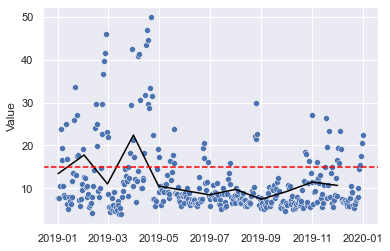

In [115]:
sns.scatterplot(x=dep_df['Date'].unique(), y=dep_df.groupby('Date').mean()['Value'])
plt.plot(dep_df[dep_df['dayofmonth']==1].Date.unique(), 
         dep_df.groupby('month').mean()['Value'], color='black')

plt.axhline(y=15, color='red', linestyle='--')
plt.show()

In [ ]:
# number of date above WHO guideline
(dep_df.groupby('Date').mean()['Value']>15).sum()

In [ ]:
# annual mean for each site
dep_df.groupby('Site').mean()['Value']

In [ ]:
# annual mean for London
dep_df['Value'].mean()

In [10]:
area_names = []
edge_names = []
for i in range(2, 7):
    area_names.append(exp_df.columns[2*i-1])
    edge_names.append(exp_df.columns[2*i])
print(area_names, edge_names)

['UnC_area_per_len', 'A_area_per_len', 'B_area_per_len', 'CUn_area_per_len', 'Other_area_per_len'] ['UnC_edge_per_len', 'A_edge_per_len', 'B_edge_per_len', 'CUn_edge_per_len', 'Other_edge_per_len']


In [11]:
var_names = area_names + edge_names

In [12]:
# kernel weight matrix for the sites
weight = Kernel.from_dataframe(loc_gdf, geom_col='geometry', function='gaussian')

In [13]:
for var in area_names+edge_names:
    moran_temp = Moran(exp_df[var].values, weight)
    print("Global Moran's I for " + var + ' is ', round(moran_temp.I, 5), 
          ' p-value: ', round(moran_temp.p_norm, 5))

Global Moran's I for UnC_area_per_len is  0.22651  p-value:  0.0
Global Moran's I for A_area_per_len is  0.1898  p-value:  4e-05
Global Moran's I for B_area_per_len is  0.02886  p-value:  0.17844
Global Moran's I for CUn_area_per_len is  0.15787  p-value:  0.00039
Global Moran's I for Other_area_per_len is  0.19556  p-value:  3e-05
Global Moran's I for UnC_edge_per_len is  0.16823  p-value:  0.0002
Global Moran's I for A_edge_per_len is  0.19947  p-value:  2e-05
Global Moran's I for B_edge_per_len is  0.01378  p-value:  0.27646
Global Moran's I for CUn_edge_per_len is  0.08091  p-value:  0.02551
Global Moran's I for Other_edge_per_len is  0.10941  p-value:  0.00653


<AxesSubplot:xlabel='hour'>

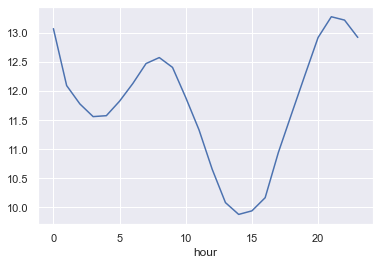

In [86]:
dep_df.groupby('hour').mean()['Value'].plot()

<AxesSubplot:xlabel='dayofweek'>

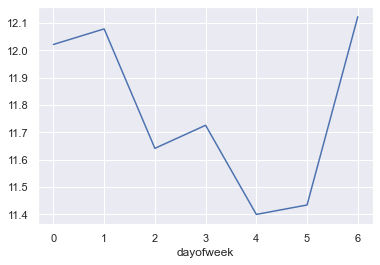

In [14]:
dep_df['dayofweek'] = dep_df['DateTime'].dt.dayofweek
dep_df.groupby('dayofweek').mean()['Value'].plot()

In [ ]:
dep_df.groupby('dayofmonth').mean()['Value'].plot()

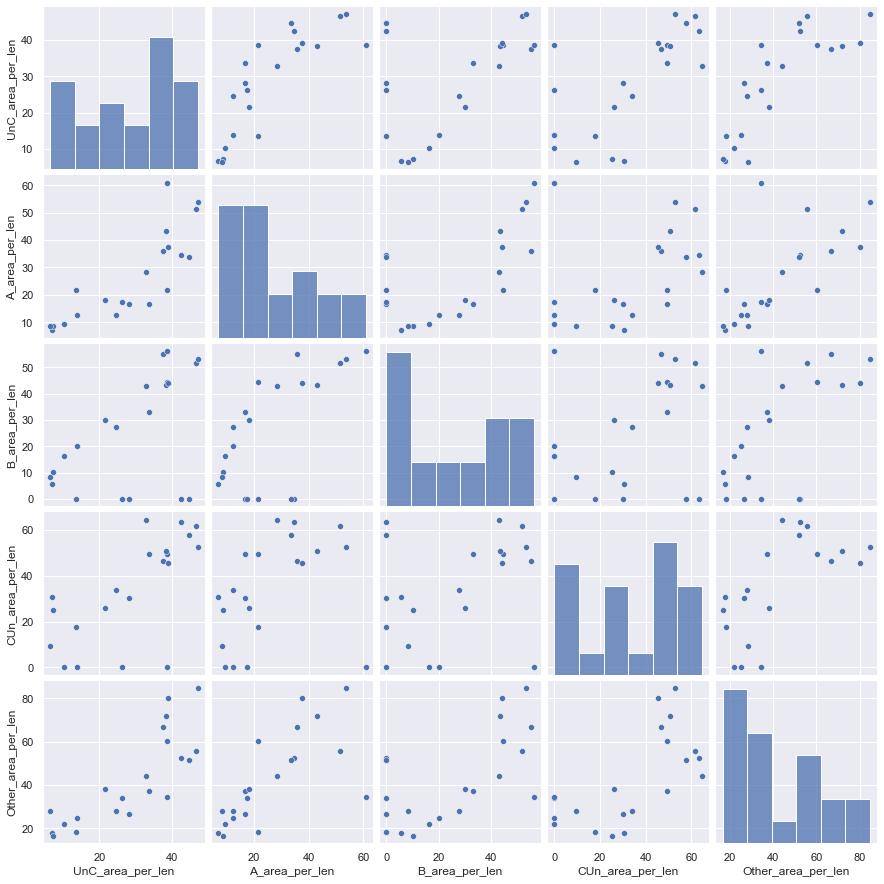

In [15]:
sns.pairplot(exp_df[area_names])

In [25]:
exp_df[area_names].describe()

,UnC_area_per_len,A_area_per_len,B_area_per_len,CUn_area_per_len,Other_area_per_len
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,28.520807,26.246194,25.788827,34.007412,42.497226
std,14.016818,16.163453,21.169168,22.542926,21.026566
min,6.461089,7.084152,0.000000,0.000000,16.415021
25%,13.888893,12.595197,5.633153,17.717612,26.381062
50%,32.957256,21.628544,27.486036,33.960430,37.116369
75%,38.753776,35.940536,44.131224,50.730381,55.766749
max,47.129151,60.890307,56.162862,64.512992,84.755679


In [116]:
def get_importance(reg, features, target, feature_names, state=25, rep=50, method='r2'):
    mean = []
    std = []
    reg.fit(features, target)
    importance = permutation_importance(reg, features, target, n_repeats=rep,
                                        random_state=state, scoring=method)
    for i in range(len(feature_names)):
        mean.append(round(importance.importances_mean[i], 5))
        std.append(round(importance.importances_std[i], 5))
    return mean, std

In [96]:
def get_cv(reg, features, target, iter=100, n_splits=5, loo=False):
    cv_r2 = []
    cv_tau = []
    cv_resid = []
    if loo:
        split = LeaveOneOut()
        iter = 1
    for i in range(iter):
        if not loo:
            split = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        cvprd = cross_val_predict(reg, features, target, cv=split)
        
        r = stats.pearsonr(target,cvprd)[0]
        t, p_value = stats.kendalltau(target, cvprd)
        resid = cvprd - target
        
        cv_r2.append(r**2)
        cv_tau.append(t)
        cv_resid.append(resid)

    return [round(np.mean(cv_r2),5), round(np.std(cv_r2),5),
            round(np.mean(cv_tau),5), round(np.std(cv_tau),5),
            np.mean(np.array(cv_resid), axis=0)]

In [18]:
reg = LinearRegression()

In [19]:
annual = exp_df.merge(dep_df.groupby('Site').mean()[['Value']], left_on='siteid', right_index=True)
annual.head()

,siteid,Gsp_area,Gsp_edge,UnC_area_per_len,UnC_edge_per_len,A_area_per_len,A_edge_per_len,B_area_per_len,B_edge_per_len,CUn_area_per_len,CUn_edge_per_len,Other_area_per_len,Other_edge_per_len,Gsp_per_tRd_len,Value
0,BX9,1.576555e+06,255419.318823,42.547777,9.767029,34.722332,8.261647,0.000000,0.000000,63.364634,12.808025,52.384408,10.927710,43.115555,11.170749
1,BL0,5.540353e+05,157341.593174,10.218919,3.513516,9.464790,3.272898,16.140991,5.821449,0.000000,0.000000,21.815012,7.425750,8.363151,10.908521
2,CD9,6.694895e+05,182451.758811,13.888893,4.585492,12.595197,4.152965,20.121072,6.541948,0.000000,0.000000,24.772259,7.744211,11.040183,13.712563
3,CD1,1.418894e+06,279764.153943,33.768627,7.834793,16.790598,5.071586,32.863003,8.520570,49.419568,12.634713,37.116369,10.013259,27.536701,11.058464
4,CT2,3.981578e+05,80239.660463,6.777993,1.701836,7.084152,1.925169,5.633153,2.712272,30.535483,4.393786,17.630140,4.800286,7.360219,13.902287


In [20]:
Moran(annual['Value'].values, weight).I

0.0960805356530469

In [119]:
y = annual['Value'].values
X = annual[area_names].values

In [124]:
# feature importance
get_importance(reg, X, y, area_names)

([1.63613, 0.19492, 0.49033, 0.61434, 0.2002],
 [0.55218, 0.10694, 0.22777, 0.24394, 0.13459])

In [90]:
# coefficient
reg.coef_

array([-0.10841385,  0.03010942,  0.03779141,  0.03916031, -0.02523263])

In [91]:
# r2
reg.score(X,y)

0.365064847871562

In [92]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, reg.predict(X))

1.5958982026390527

In [97]:
# cross validation r2 and tau
get_cv(reg, X, y, loo=True)

[0.08144,
 0.0,
 0.07619,
 0.0,
 array([-1.16477859,  1.43446761, -2.28106682,  1.23100786, -0.85619942,
         1.47089549,  1.79574319,  1.87708538, -0.40099349, -0.28459951,
        -1.54635138, -1.44411554, -0.1239867 ,  0.84468749,  2.9402903 ,
         2.36256793, -3.14251197, -0.76127703,  0.03531615, -0.48762403,
        -2.40246668])]

<AxesSubplot:ylabel='Count'>

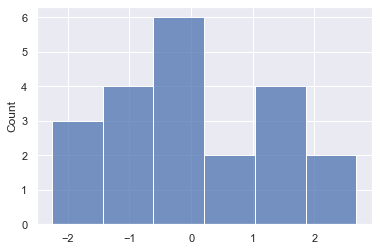

In [98]:
# residuals histogram
sns.histplot(reg.predict(X)-y)

In [99]:
# global moran's I for the residuals
Moran(reg.predict(X)-y, weight).I, Moran(reg.predict(X)-y, weight).p_norm

(0.03154472979913803, 0.1641157531980464)

In [29]:
hm_dep_df = dep_df.groupby(['hour', 'Site']).mean()
hm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Value       504 non-null    float64
 1   month       504 non-null    float64
 2   dayofmonth  504 non-null    float64
 3   dayofweek   504 non-null    float64
dtypes: float64(4)
memory usage: 17.2+ KB


In [30]:
hm_dep_df.drop(['dayofweek', 'dayofmonth', 'month'], axis=1, inplace=True)
hm_dep_df.reset_index(inplace=True)

In [31]:
hm_dep_df = hm_dep_df.merge(exp_df, left_on='Site', right_on='siteid')
hm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hour                504 non-null    int64  
 1   Site                504 non-null    object 
 2   Value               504 non-null    float64
 3   siteid              504 non-null    object 
 4   Gsp_area            504 non-null    float64
 5   Gsp_edge            504 non-null    float64
 6   UnC_area_per_len    504 non-null    float64
 7   UnC_edge_per_len    504 non-null    float64
 8   A_area_per_len      504 non-null    float64
 9   A_edge_per_len      504 non-null    float64
 10  B_area_per_len      504 non-null    float64
 11  B_edge_per_len      504 non-null    float64
 12  CUn_area_per_len    504 non-null    float64
 13  CUn_edge_per_len    504 non-null    float64
 14  Other_area_per_len  504 non-null    float64
 15  Other_edge_per_len  504 non-null    float64
 16  Gsp_per_

In [32]:
hm_dep_df.drop('Site', axis=1, inplace=True)

In [44]:
hm_X = hm_dep_df[area_names].values
hm_y = hm_dep_df['Value'].values

In [51]:
get_importance(reg, hm_X, hm_y, area_names, rep=100)

([1.03677, 0.10584, 0.28583, 0.35655, 0.1271],
 [0.06947, 0.02086, 0.03266, 0.0358, 0.02181])

In [46]:
reg.score(hm_X, hm_y)

0.2166148137531405

In [37]:
get_cv(reg, hm_X, hm_y, n_splits=10)

[0.19993,
 0.00307,
 0.29206,
 0.00494,
 array([ 6.66094595e-01,  6.88209248e-01,  1.10701202e+00,  1.53958028e+00,
         1.48812534e+00,  1.45158451e+00,  1.13989768e+00,  7.10414185e-01,
         5.90531223e-01,  3.97723073e-01,  9.39521790e-01,  1.39013633e+00,
         2.19354570e+00,  2.72614131e+00,  2.84393985e+00,  2.95118832e+00,
         2.68739153e+00,  1.94118655e+00,  1.05602651e+00,  3.43543516e-01,
        -2.41869737e-01, -4.75181229e-01, -1.46332644e-01,  2.94654986e-01,
        -1.87503152e+00, -1.39810574e+00, -1.09881412e+00, -6.88148175e-01,
        -8.57059148e-01, -9.82150527e-01, -1.27223470e+00, -1.41512557e+00,
        -1.32661950e+00, -1.10869016e+00, -7.66100283e-01, -6.02901459e-01,
         2.83747920e-01,  1.01824187e+00,  1.32139566e+00,  1.15213208e+00,
         9.50726953e-01,  2.62865955e-01, -4.03530554e-01, -1.07022288e+00,
        -1.65358116e+00, -1.90761703e+00, -2.20540645e+00, -2.28134880e+00,
         9.98487200e-01,  1.63648753e+00,  1.968

In [47]:
# check global moran's I
for h in range(24):
    df = hm_dep_df[hm_dep_df['hour']==h].copy()
    print("Global Moran's I for hour ", h+1, " is: ", Moran(df['Value'].values, weight).I)

Global Moran's I for hour  1  is:  0.06497149669113031
Global Moran's I for hour  2  is:  0.0245776965350352
Global Moran's I for hour  3  is:  0.023679068042262625
Global Moran's I for hour  4  is:  0.022407841453422502
Global Moran's I for hour  5  is:  0.010815062841263887
Global Moran's I for hour  6  is:  0.015475583335916723
Global Moran's I for hour  7  is:  0.022795098109670307
Global Moran's I for hour  8  is:  0.03812792090918269
Global Moran's I for hour  9  is:  0.061859833103432335
Global Moran's I for hour  10  is:  0.06864587291469511
Global Moran's I for hour  11  is:  0.07152289068767917
Global Moran's I for hour  12  is:  0.05695064983154796
Global Moran's I for hour  13  is:  0.044951223755330394
Global Moran's I for hour  14  is:  0.036635569274802986
Global Moran's I for hour  15  is:  0.018729390685179557
Global Moran's I for hour  16  is:  0.001011166962265878
Global Moran's I for hour  17  is:  -0.0071881322024358145
Global Moran's I for hour  18  is:  -0.008536

In [100]:
# linear models by each hour
hm_reg = []
for h in range(24):
    df = hm_dep_df[hm_dep_df['hour']==h].copy()
    X = df[area_names].values
    y = df['Value'].values
    
    mean, std = get_importance(reg, X, y, area_names)
    coef = reg.coef_.tolist() + [reg.intercept_]
    r2 = reg.score(X, y)
    cv = get_cv(reg, X, y, loo=True)
    
    hm_reg.append(mean+std+coef+[r2]+cv)

hm_reg = pd.DataFrame(hm_reg, columns=['fi_'+var for var in area_names]+
                      ['fi_std_'+var for var in area_names]+
                      area_names+['intercept','r2','cv_r2','std_r2','cv_tau','std_tau','resid'])

<AxesSubplot:>

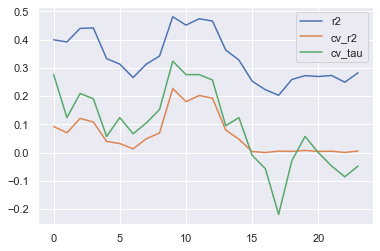

In [101]:
# model performance
hm_reg[['r2', 'cv_r2', 'cv_tau']].plot()

In [135]:
hm_reg[['r2', 'cv_r2', 'cv_tau']].mean()

r2        0.337019
cv_r2     0.064983
cv_tau    0.092460
dtype: float64

No handles with labels found to put in legend.


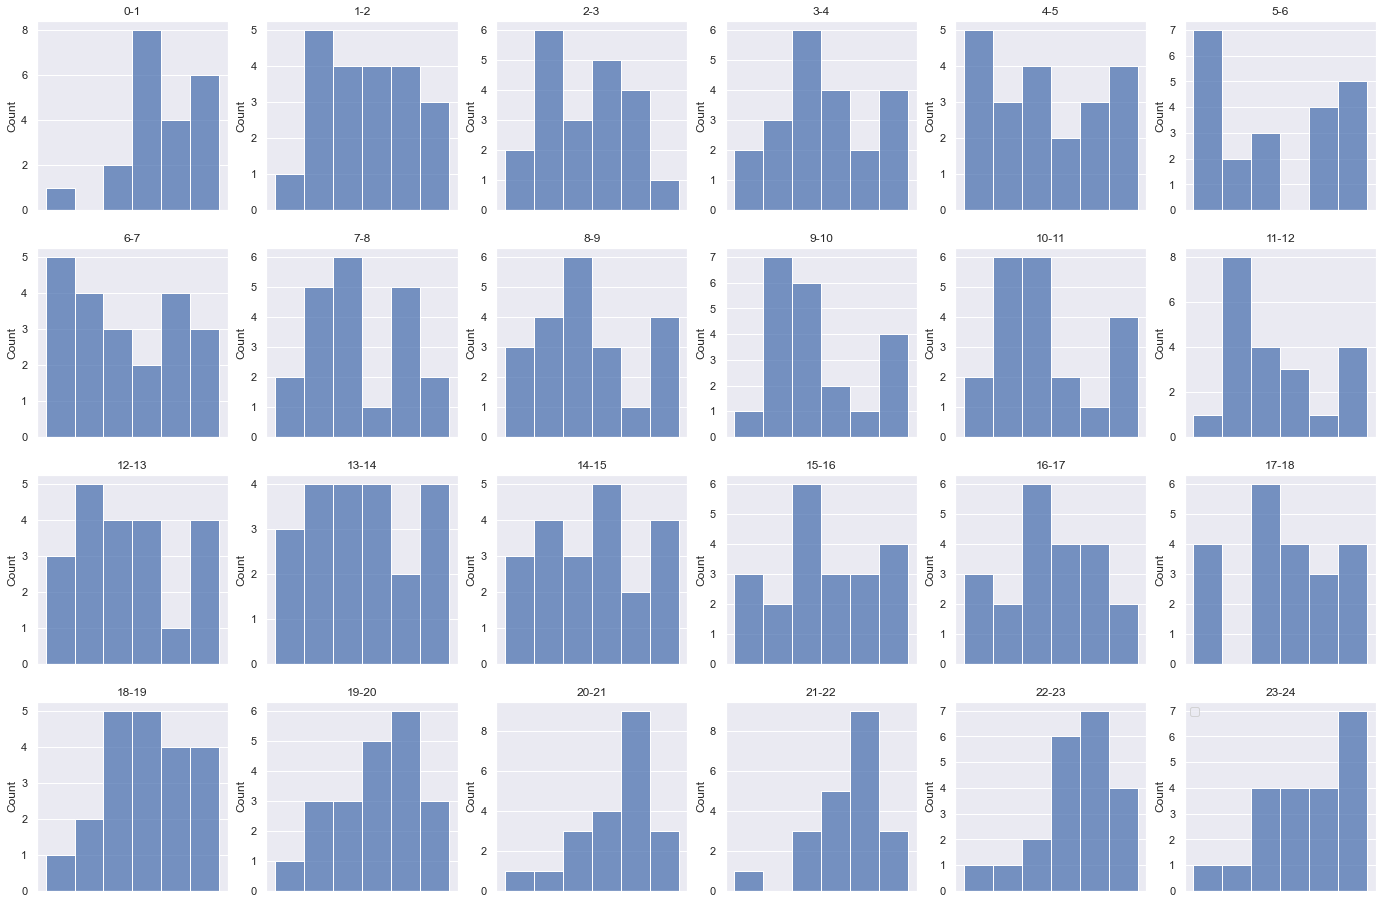

In [108]:
# histogram for residuals
fig, ax = plt.subplots(4, 6, figsize=(24, 16))

for hour in range(24):
    sns.histplot(hm_reg.loc[hour,'resid'], ax=ax[hour//6, hour%6])
    ax[hour//6, hour%6].get_xaxis().set_ticks([])
    ax[hour//6, hour%6].set_title(str(hour)+'-'+str(hour+1))
plt.legend()
plt.show()

In [103]:
for h in range(24):
    resid = hm_reg.loc[h, 'resid']
    print("Global Moran's I for residuals for month ", h, " is: ", 
          Moran(resid, weight).I, " p-value: ",Moran(resid, weight).p_norm)

Global Moran's I for residuals for month  0  is:  0.08526918977846121  p-value:  0.020996993438289646
Global Moran's I for residuals for month  1  is:  0.017680790831707732  p-value:  0.24816927037495295
Global Moran's I for residuals for month  2  is:  0.024961330542104306  p-value:  0.20088574325269315
Global Moran's I for residuals for month  3  is:  0.031908795653333044  p-value:  0.16224113298007747
Global Moran's I for residuals for month  4  is:  -0.009099531308112231  p-value:  0.4852605860352657
Global Moran's I for residuals for month  5  is:  -0.006047326898875781  p-value:  0.45328778340140774
Global Moran's I for residuals for month  6  is:  0.0039050775523988626  p-value:  0.35769893977484557
Global Moran's I for residuals for month  7  is:  0.010235774865333181  p-value:  0.30405499039356254
Global Moran's I for residuals for month  8  is:  0.035738418628806425  p-value:  0.14349013902280094
Global Moran's I for residuals for month  9  is:  0.04407216664248342  p-value: 

No handles with labels found to put in legend.


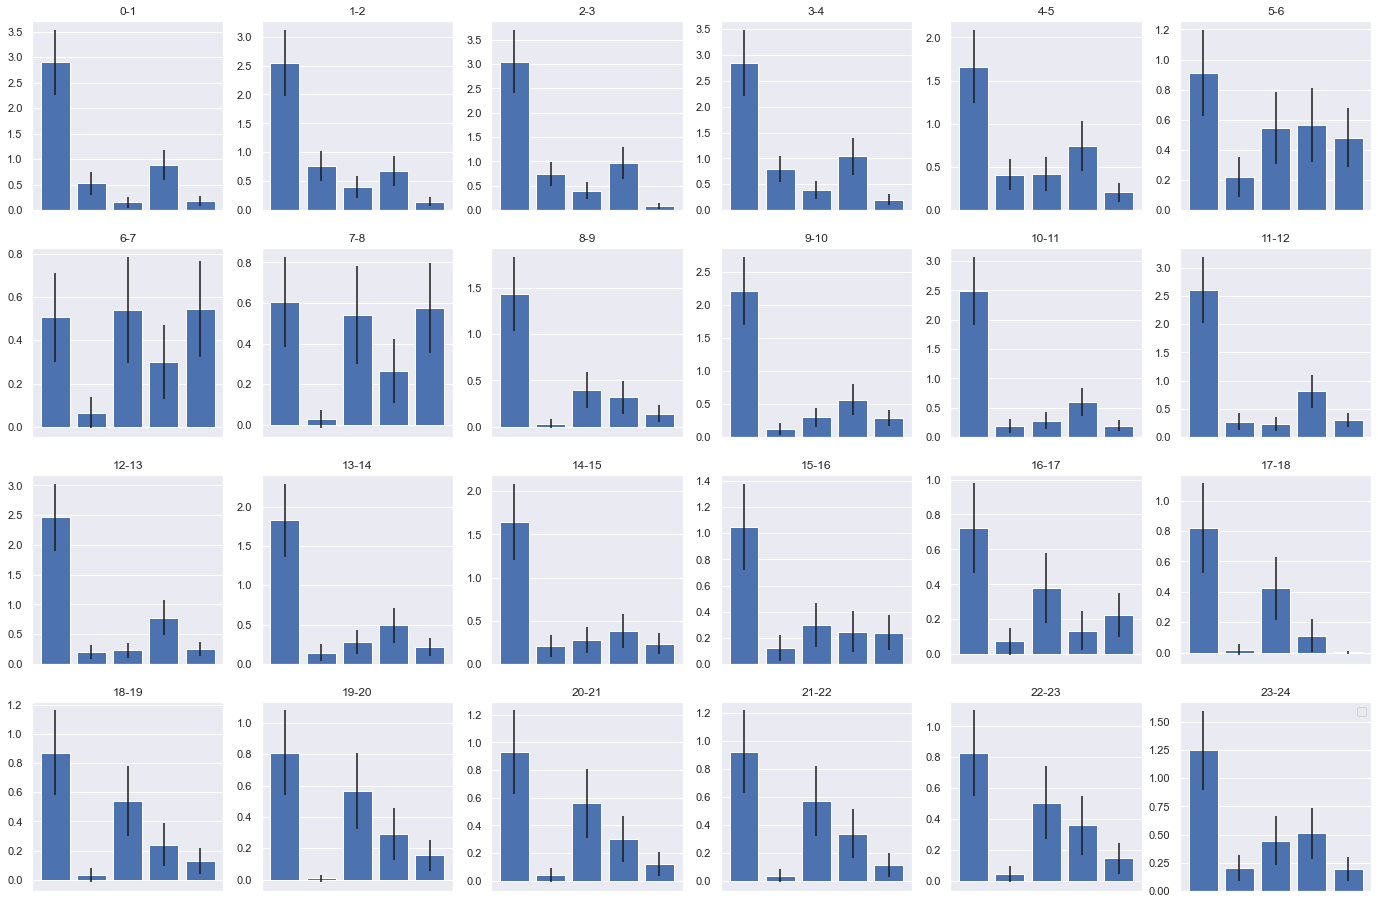

In [107]:
# plot feature importance
fig, ax = plt.subplots(4, 6, figsize=(24, 16))

for hour in range(24):
    ax[hour//6, hour%6].bar(['fi_' + elem for elem in area_names], 
                            hm_reg.loc[hour, ['fi_' + elem for elem in area_names]].values,
                            yerr=hm_reg.loc[hour, ['fi_std_' + elem for elem in area_names]].values)
    ax[hour//6, hour%6].get_xaxis().set_ticks([])
    ax[hour//6, hour%6].set_title(str(hour)+'-'+str(hour+1))
plt.legend()
plt.show()

In [138]:
hm_reg[['fi_' + elem for elem in area_names]]

,fi_UnC_area_per_len,fi_A_area_per_len,fi_B_area_per_len,fi_CUn_area_per_len,fi_Other_area_per_len
0,2.89752,0.52514,0.15060,0.87525,0.17308
1,2.54346,0.76688,0.40381,0.67547,0.14790
2,3.04762,0.74466,0.40039,0.96262,0.09093
3,2.84563,0.79275,0.38699,1.03794,0.20031
4,1.66248,0.41197,0.41628,0.74370,0.20721
5,0.91135,0.22256,0.54683,0.56560,0.48109
6,0.50574,0.06619,0.54006,0.30065,0.54509
7,0.60714,0.02603,0.54201,0.26533,0.57473
8,1.43470,0.03476,0.39445,0.31851,0.14274
9,2.20978,0.12351,0.29776,0.56370,0.28530


In [140]:
hm_reg[['fi_' + elem for elem in area_names]+['fi_std_' + elem for elem in area_names]].mean()

fi_UnC_area_per_len          1.579155
fi_A_area_per_len            0.220983
fi_B_area_per_len            0.402697
fi_CUn_area_per_len          0.495841
fi_Other_area_per_len        0.224235
fi_std_UnC_area_per_len      0.410064
fi_std_A_area_per_len        0.114360
fi_std_B_area_per_len        0.192508
fi_std_CUn_area_per_len      0.217560
fi_std_Other_area_per_len    0.113762
dtype: float64

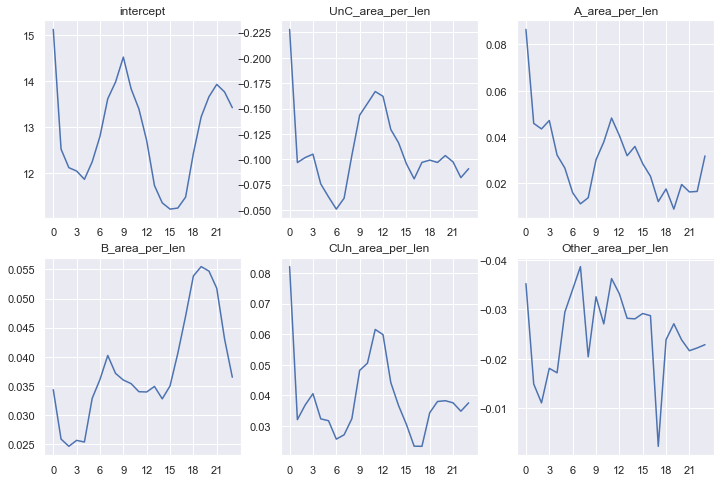

In [159]:
# coefficient viz
fig,ax=plt.subplots(2,3,figsize=(12,8))
col = ['intercept']+area_names
for i in range(len(col)):
    hm_reg[col[i]].plot(ax=ax[i//3,i%3])
    ax[i//3,i%3].set_title(col[i])
    ax[i//3,i%3].set_xticks([3*i for i in range(8)])
    if hm_reg[col[i]].mean()<0:
        ax[i//3,i%3].invert_yaxis()
plt.show()

In [58]:
mm_dep_df = dep_df.groupby(['month','Site']).mean()
mm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (1, 'BL0') to (12, 'TH4')
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Value       252 non-null    float64
 1   hour        252 non-null    float64
 2   dayofmonth  252 non-null    float64
 3   dayofweek   252 non-null    float64
dtypes: float64(4)
memory usage: 8.7+ KB


In [59]:
mm_dep_df.drop(['hour', 'dayofmonth', 'dayofweek'], axis=1, inplace=True)
mm_dep_df.reset_index(inplace=True)

In [60]:
mm_dep_df = mm_dep_df.merge(exp_df, left_on='Site', right_on='siteid')
mm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               252 non-null    int64  
 1   Site                252 non-null    object 
 2   Value               252 non-null    float64
 3   siteid              252 non-null    object 
 4   Gsp_area            252 non-null    float64
 5   Gsp_edge            252 non-null    float64
 6   UnC_area_per_len    252 non-null    float64
 7   UnC_edge_per_len    252 non-null    float64
 8   A_area_per_len      252 non-null    float64
 9   A_edge_per_len      252 non-null    float64
 10  B_area_per_len      252 non-null    float64
 11  B_edge_per_len      252 non-null    float64
 12  CUn_area_per_len    252 non-null    float64
 13  CUn_edge_per_len    252 non-null    float64
 14  Other_area_per_len  252 non-null    float64
 15  Other_edge_per_len  252 non-null    float64
 16  Gsp_per_

In [61]:
mm_dep_df.drop('Site', axis=1, inplace=True)

In [62]:
for m in range(1,13):
    df = mm_dep_df[mm_dep_df['month']==m].copy()
    print("Global Moran's I for month ", m, "is: ", Moran(df['Value'].values, weight).I)

Global Moran's I for month  1 is:  0.003641632057737503
Global Moran's I for month  2 is:  0.0662609644851644
Global Moran's I for month  3 is:  0.13033251481287086
Global Moran's I for month  4 is:  -0.007821811529515265
Global Moran's I for month  5 is:  0.057814827084503126
Global Moran's I for month  6 is:  0.07317506194877035
Global Moran's I for month  7 is:  0.016624172348547708
Global Moran's I for month  8 is:  0.015710564641922425
Global Moran's I for month  9 is:  0.05979959100051212
Global Moran's I for month  10 is:  0.08902715229331153
Global Moran's I for month  11 is:  0.05306934244532968
Global Moran's I for month  12 is:  0.10564724933858408


In [63]:
mm_X = mm_dep_df[area_names].values
mm_y = mm_dep_df['Value'].values

In [64]:
get_importance(reg, mm_X, mm_y, area_names, rep=100)

([0.21706, 0.02065, 0.0576, 0.07048, 0.02731],
 [0.04393, 0.01299, 0.02094, 0.02443, 0.01592])

In [65]:
get_cv(reg, mm_X, mm_y, n_splits=10)

[0.01016,
 0.0042,
 0.119,
 0.01411,
 array([-1.72977103e+00, -5.77396407e+00,  2.17606426e+00, -1.01388662e+01,
         3.16323284e+00,  3.89062993e+00,  4.98343319e+00,  3.71351462e+00,
         6.14478550e+00,  4.01938238e+00,  1.66928534e+00,  2.14786358e+00,
        -4.31222193e+00, -8.48436494e+00, -9.09271431e-01, -1.29484612e+01,
         7.90752282e-01,  2.93478531e+00,  4.79252818e+00,  4.96843045e+00,
         2.95072532e+00,  1.57359379e+00,  5.73526014e-01, -1.18129487e+00,
        -7.98444521e-01, -6.35923596e+00,  2.19034092e+00, -1.02090420e+01,
         2.37898095e+00,  3.75207325e+00,  4.54754323e+00,  3.35304704e+00,
         5.56239126e+00,  3.35821029e+00,  5.93243654e-01,  2.18226076e+00,
        -3.33976125e+00, -1.02807075e+01, -7.59254481e-01, -1.25898852e+01,
         9.79362553e-01,  1.52479491e+00,  1.69844967e+00, -2.58874608e-01,
         2.32866788e+00, -6.24540961e-02, -2.56266402e+00,  2.91072712e-01,
        -1.50238252e+00, -3.68128072e+00,  2.009817

In [109]:
# linear models by each month
mm_reg = []
for m in range(1,13):
    df = mm_dep_df[mm_dep_df['month']==m].copy()
    X = df[area_names].values
    y = df['Value'].values
    
    mean, std = get_importance(reg, X, y, area_names)
    coef = reg.coef_.tolist() + [reg.intercept_]
    r2 = reg.score(X, y)
    cv = get_cv(reg, X, y, loo=True)
    
    mm_reg.append(mean+std+coef+[r2]+cv)

mm_reg = pd.DataFrame(mm_reg, columns=['fi_'+var for var in area_names]+
                      ['fi_std_'+var for var in area_names]+
                      area_names+['intercept','r2','cv_r2','std_r2','cv_tau','std_tau','resid'])

<AxesSubplot:>

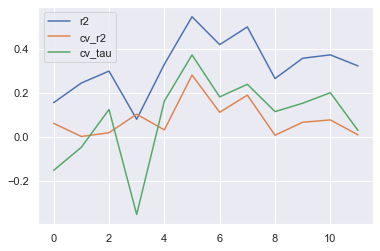

In [69]:
# model performance
mm_reg[['r2', 'cv_r2', 'cv_tau']].plot()

No handles with labels found to put in legend.


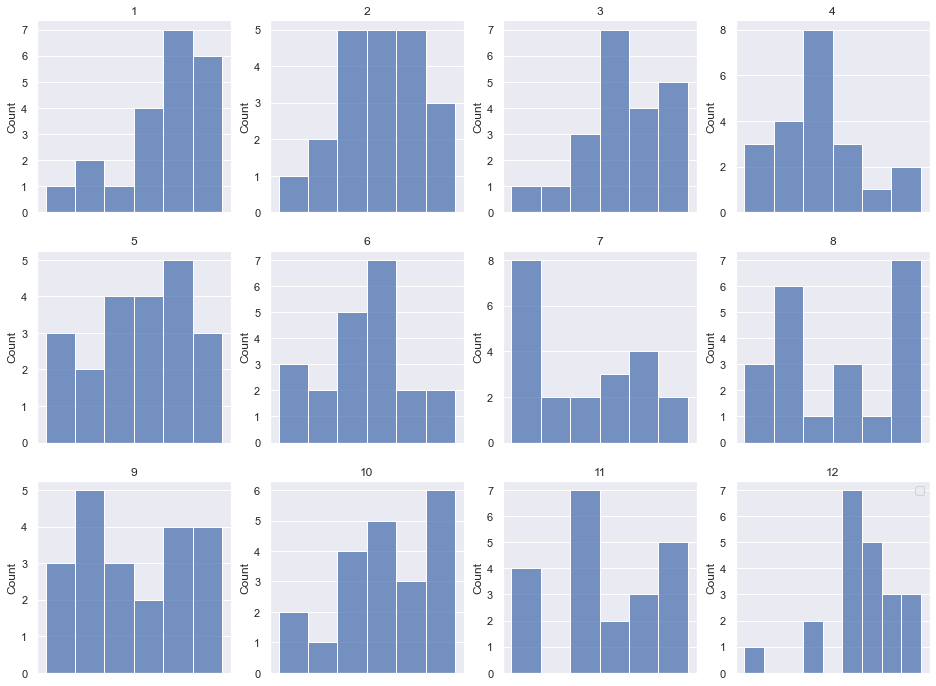

In [113]:
# histogram for residuals
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for month in range(12):
    sns.histplot(mm_reg.loc[month,'resid'], ax=ax[month//4, month%4])
    ax[month//4, month%4].get_xaxis().set_ticks([])
    ax[month//4, month%4].set_title(month+1)
plt.legend()
plt.show()

In [73]:
for m in range(12):
    resid = mm_reg.loc[m, 'resid']
    print("Global Moran's I for residuals for month ", m+1, " is: ", Moran(resid, weight).I)

Global Moran's I for residuals for month  1  is:  -0.0008782486805908661
Global Moran's I for residuals for month  2  is:  0.06609368032560305
Global Moran's I for residuals for month  3  is:  0.08279553474942927
Global Moran's I for residuals for month  4  is:  0.014224891199051593
Global Moran's I for residuals for month  5  is:  0.014277374642435253
Global Moran's I for residuals for month  6  is:  0.08420680063133568
Global Moran's I for residuals for month  7  is:  0.022846624416685765
Global Moran's I for residuals for month  8  is:  0.018585202020258852
Global Moran's I for residuals for month  9  is:  0.017548951329757125
Global Moran's I for residuals for month  10  is:  0.02911623832265488
Global Moran's I for residuals for month  11  is:  0.02780130619327996
Global Moran's I for residuals for month  12  is:  0.11965867076691684


No handles with labels found to put in legend.


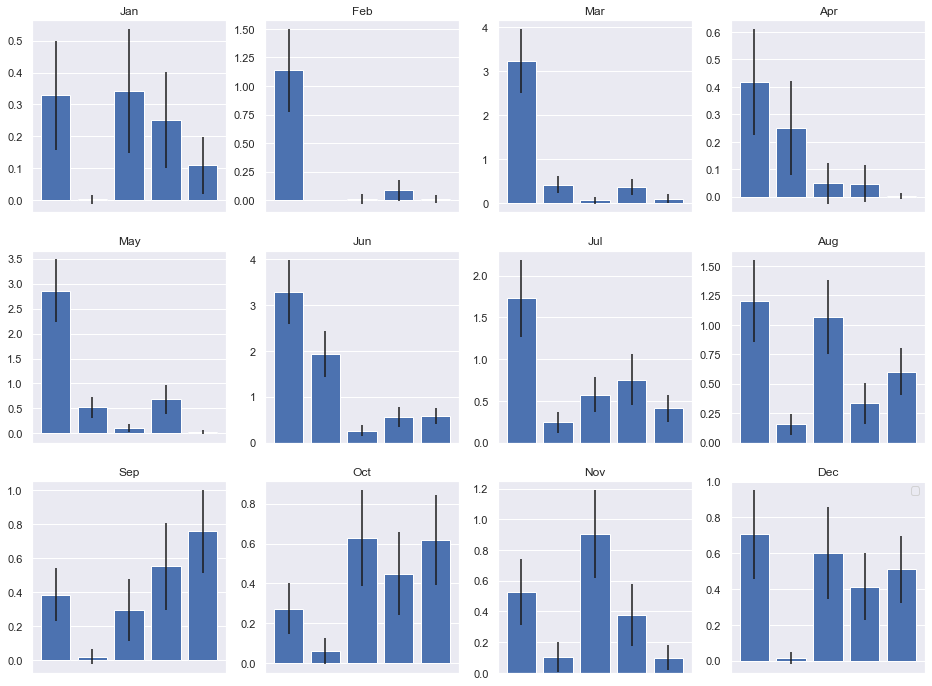

In [154]:
# plot feature importance
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
mlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for month in range(12):
    ax[month//4, month%4].bar(['fi_' + elem for elem in area_names], 
                              mm_reg.loc[month, ['fi_' + elem for elem in area_names]].values,
                              yerr=mm_reg.loc[month, ['fi_std_' + elem for elem in area_names]].values)
    ax[month//4, month%4].get_xaxis().set_ticks([])
    ax[month//4, month%4].set_title(mlabels[month])
plt.legend()
plt.show()

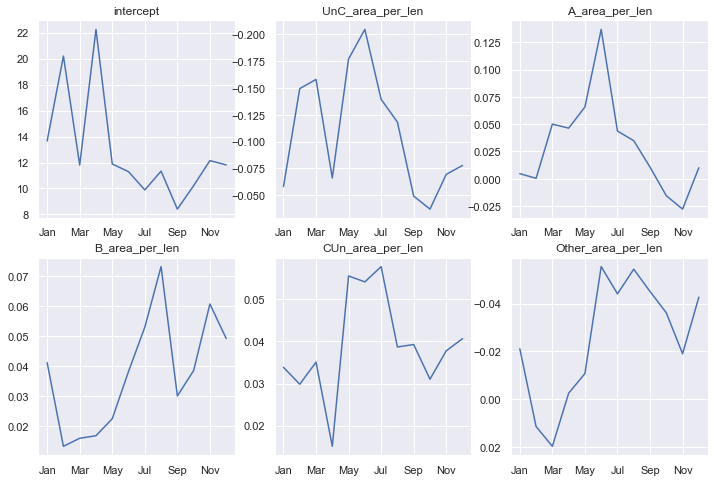

In [157]:
# coefficient viz
fig,ax=plt.subplots(2,3,figsize=(12,8))
col = ['intercept']+area_names
for i in range(len(col)):
    mm_reg[col[i]].plot(ax=ax[i//3,i%3])
    ax[i//3,i%3].set_title(col[i])
    ax[i//3,i%3].set_xticks([0,2,4,6,8,10])
    ax[i//3,i%3].set_xticklabels([mlabels[2*i] for i in range(6)])
    if mm_reg[col[i]].mean()<0:
        ax[i//3,i%3].invert_yaxis()
plt.show()

In [ ]:
moran = []
for time in df['DateTime'].unique():
    moran_temp = Moran(df[df['DateTime']==time].log_Value.values, weight)
    moran.append([round(moran_temp.I, 5), round(moran_temp.p_norm, 5)])
moran_df = pd.DataFrame(df['DateTime'].unique(), columns=['DateTime'])
moran_df[['moran', 'p-value']] = moran
moran_df.head()

In [ ]:
moran_df['hour'] = moran_df['DateTime'].dt.hour

In [ ]:
fig,ax = plt.subplots(4, 6, figsize=(24,16))
i = 0
for hour in range(24):
    sns.lineplot(x=moran_df['DateTime'].dt.date.unique(), 
                 y=moran_df[moran_df['hour']==hour].moran.values, 
                 ax=ax[i//6, i%6], linewidth=1)
    i+=1
plt.show()

In [ ]:
h_fi = []
h_score = []
h_coef = []
for hour in df['hour'].unique():
    X = df[df['hour']==hour].loc[:,t_var].values
    y = df[df['hour']==hour].loc[:,'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=t_var)
    h_fi.append(fi_mean + fi_std)
    
    h_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    h_coef.append(coef)
    
h_fi = pd.DataFrame(h_fi, columns=['fi_' + elem for elem in t_var] + ['fi_std_' + elem for elem in t_var])
h_score = pd.DataFrame(h_score, columns=['r2'])
h_coef = pd.DataFrame(h_coef, columns=t_var+['intercept'])

In [ ]:
h_reg = pd.concat([h_coef, h_score, h_fi], axis=1)
h_reg

In [ ]:
h_reg['r2'].plot()

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in t_var], y=h_reg.loc[hour, ['fi_' + elem for elem in t_var]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [ ]:
# set up a new column for month information
df['month'] = df['DateTime'].dt.month

In [ ]:
moran_df['month'] = moran_df['DateTime'].dt.month

In [ ]:
fig,ax = plt.subplots(3, 4, figsize=(16,12))
i = 0
for month in range(1,13):
    sns.lineplot(x='DateTime', y='moran', data=moran_df[moran_df['month']==month],
                 ax=ax[i//4, i%4], linewidth=1)
    i+=1
plt.show()

In [ ]:
m_fi = []
m_score = []
m_coef = []
for month in df['month'].unique():
    X = df[df['month']==month].loc[:, t_var].values
    y = df[df['month']==month].loc[:, 'log_Value'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=25)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    reg.fit(X_train, y_train)
    
    fi_mean, fi_std = get_importance(reg, X_test, y_test, feature_names=t_var)
    m_fi.append(fi_mean + fi_std)

    m_score.append(reg.score(X_test, y_test))
    
    coef = reg.coef_.tolist()
    coef.append(reg.intercept_)
    m_coef.append(coef)
    
m_fi = pd.DataFrame(m_fi, columns=['fi_' + elem for elem in t_var] + ['fi_std_' + elem for elem in t_var])
m_score = pd.DataFrame(m_score, columns=['r2'])
m_coef = pd.DataFrame(m_coef, columns=t_var+['intercept'])

In [ ]:
m_reg = pd.concat([m_coef, m_score, m_fi], axis=1)
m_reg

In [ ]:
m_reg['r2'].plot()

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in t_var], y=m_reg.loc[month-1, ['fi_' + elem for elem in t_var]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [ ]:
df.groupby('month').mean()['Value'].plot()

In [ ]:
df.info()

In [ ]:
high_period = df[df['month'].isin([1, 2, 4])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)
low_period = df[~df['month'].isin([1, 2, 4])].drop(['hour','dayofweek','dayofmonth','month'],axis=1)

print('high period: '+str(high_period.shape)+'\nlow period: '+str(low_period.shape))

In [ ]:
hp_X = high_period[t_var].values
hp_y = high_period['log_Value'].values

hp_X_train, hp_X_test, hp_y_train, hp_y_test = train_test_split(hp_X, hp_y, shuffle=True, random_state=25)

hp_X_train = scaler.fit_transform(hp_X_train)
hp_X_test = scaler.fit_transform(hp_X_test)

reg.fit(hp_X_train, hp_y_train)

get_importance(reg, hp_X_test, hp_y_test, feature_names=t_var)

In [ ]:
reg.score(hp_X_test, hp_y_test)

In [ ]:
reg.coef_.tolist() + [reg.intercept_]

In [ ]:
lp_X = low_period[t_var].values
lp_y = low_period['log_Value'].values

lp_X_train, lp_X_test, lp_y_train, lp_y_test = train_test_split(lp_X, lp_y, shuffle=True, random_state=25)
lp_X_train = scaler.fit_transform(lp_X_train)
lp_X_test = scaler.fit_transform(lp_X_test)
reg.fit(lp_X_train, lp_y_train)

get_importance(reg, lp_X_test, lp_y_test, feature_names=t_var)

In [ ]:
reg.score(lp_X_test, lp_y_test)

In [ ]:
reg.coef_.tolist() + [reg.intercept_]

# Mean analysis

In [ ]:
def get_corr(df, iter_range, method='pearson', features=t_var_names, target='log_Value'):
    result = []
    for index in iter_range:
        result.append(df.loc[(index,)].corr(method=method).loc[features,target])
    result=np.asarray(result)
    return result

In [ ]:
def get_moran(df,iter_range,w=weight,target='log_Value'):
    result=[]
    for index in iter_range:
        result.append(Moran(df.loc[(index,),target].values,w).I)
    return result

In [ ]:
def get_cv_score(reg, features, target, iter=50, split=10, method='r2'):
    score = []
    for i in range(iter):
        kf = KFold(n_splits=split, shuffle=True, random_state=i)
        cv = cross_val_score(reg, features, target, cv=kf, scoring=method).tolist()
        score = score + cv
    
    return (np.mean(score), np.std(score))

In [ ]:
def get_reg_info(df, iter_range, features=t_var_names, target='log_Value', cv_split=3, reg=LinearRegression()):
    result = []
    for index in iter_range:
        X = df.loc[(index,), features].values        
        y = df.loc[(index,), target].values
        #X = scaler.fit_transform(X)
        
        reg.fit(X, y)
        coef = reg.coef_.tolist()
        cv = get_cv(reg, X, y, splits=cv_split)
        coef = coef + cv
        importance, std = get_importance(reg, X, y, features)
        coef = coef + importance + std
        result.append(coef)
    result = pd.DataFrame(result, columns=features+['cv_r2','r2_std','cv_tau','tau_std']+
                          ['fi_'+var for var in features]+['std_fi_'+var for var in features])
    return result

In [ ]:
hm_corr=get_corr(hm_dep_df,range(24))
sns.lineplot(data=hm_corr,legend=False)
plt.legend(labels=var_names)
plt.show()

In [ ]:
hmean_corr_sp=get_corr(hm_dep_df,range(24),method='spearman')
sns.lineplot(data=hmean_corr_sp,legend=False)
plt.legend(labels=var_names)
plt.show()

In [ ]:
hmean_moran=get_moran(hm_dep_df,range(24))
sns.lineplot(x=range(24),y=hmean_moran)

In [ ]:
hmean_reg=get_reg_info(hm_dep_df,range(24), cv_split=3)
sns.lineplot(data=hmean_reg[['cv_r2','cv_tau']])

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(24, 16))
i = 0
for hour in range(24):
    g = sns.barplot(x=['fi_' + elem for elem in t_var_names], 
                    y=hmean_reg.loc[hour, ['fi_' + elem for elem in t_var_names]],
                    ax=ax[i//6, i%6])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [ ]:
hmean_x = hm_dep_df[t_var].values
hmean_y = hm_dep_df['log_Value'].values

hmean_x = scaler.fit_transform(hmean_x)
hmean_y = hmean_y.reshape(-1, 1)
hmean_y = scaler.fit_transform(hmean_y)

reg.fit(hmean_x, hmean_y)
get_cv(reg, hmean_x, hmean_y, splits=10, reshape=True)


In [ ]:
reg.coef_

In [ ]:
get_importance(reg, hmean_x, hmean_y, t_var, method='neg_mean_squared_error')

In [ ]:
mmean_df=df.groupby(['month','Site']).mean()
mmean_df.info()

In [ ]:
mmean_df.drop(['hour','dayofweek','dayofmonth'], axis=1, inplace=True)

In [ ]:
mmean_corr=get_corr(mmean_df,range(1,13))
sns.lineplot(data=mmean_corr,legend=False)
plt.legend(labels=t_var_names,loc='upper left')
plt.show()

In [ ]:
mmean_corr_sp=get_corr(mmean_df,range(1,13),method='spearman')
sns.lineplot(data=mmean_corr_sp,legend=False)
plt.legend(labels=t_var_names,loc='upper left')
plt.show()

In [ ]:
mmean_moran=get_moran(mmean_df,range(1,13))
sns.lineplot(x=range(1,13),y=mmean_moran)

In [ ]:
mmean_reg = get_reg_info(mmean_df,range(1,13),cv_split=2)
sns.lineplot(data=mmean_reg[['cv_r2','cv_tau']])

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
i = 0
for month in range(1,13):
    g = sns.barplot(x=['fi_' + elem for elem in t_var_names], 
                    y=mmean_reg.loc[month-1, ['fi_' + elem for elem in t_var_names]],
                    ax=ax[i//4, i%4])
    g.set(xticklabels=[])
    i += 1
plt.legend()
plt.show()

In [ ]:
mmean_x = mmean_df[t_var].values
mmean_y = mmean_df['log_Value'].values

mmean_x = scaler.fit_transform(mmean_x)
mmean_y = mmean_y.reshape(-1, 1)
mmean_y = scaler.fit_transform(mmean_y)

reg.fit(mmean_x, mmean_y)
get_cv(reg, mmean_x, mmean_y, splits=10, reshape=True)

In [ ]:
reg.coef_

In [ ]:
get_importance(reg, mmean_x, mmean_y, t_var, method='neg_mean_squared_error')